# Summary


Depends on `elaspic_training_interface`.

----

# Imports

In [255]:
%run imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-08-04 09:16:07.762980


In [256]:
NOTEBOOK_NAME = 'interface_machine_learning'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

os.environ['NOTEBOOK_NAME'] = NOTEBOOK_NAME
os.environ['DB_PORT'] = '8309'

In [257]:
%run mysqld.ipynb

2016-08-04 09:16:08,223 - root - INFO - MySQL database already running...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-08-04 09:16:08.146122


In [259]:
db_remote = datapkg.MySQL(
    connection_string=os.environ['DATAPKG_CONNECTION_STR'], 
    shared_folder=os.environ['NOTEBOOK_NAME'], 
    storage_host=None, 
    echo=False, 
    db_engine='InnoDB'
)

# Load data

In [ ]:
DATA_DF = pd.read_pickle(op.join('interface_load_data', 'DATA_DF_TT.pkl'))  # with test / train split

## Leave class out group

In [451]:
all_results = all_results_bak.copy()

In [452]:
def get_lco_id(pfam_clan, uniprot_id, pdb_id):
    if pd.notnull(pfam_clan):
        return pfam_clan
    elif pd.notnull(uniprot_id):
        return uniprot_id
    elif pd.notnull(pdb_id):
        return pdb_id


all_results['lco_id'] = [
    get_lco_id(*x)
    for x in all_results[['pfam_clan', 'uniprot_id', 'pdb_id']].values
]

In [453]:
print(sum(all_results['pfam_clan'].isnull()))
print(sum(all_results['lco_id'].isnull()))

1043
0


In [454]:
lco_id_counts = [tuple(x) for x in Counter(all_results['lco_id']).items()]
lco_id_counts.sort(key=lambda x: x[1], reverse=True)

In [455]:
x, y = list(zip(*lco_id_counts))

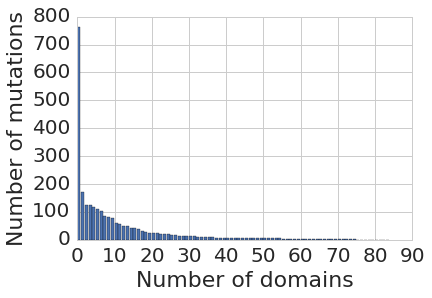

In [456]:
plt.bar(range(len(y)), y)
plt.xlabel('Number of domains')
plt.ylabel('Number of mutations')

In [457]:
def get_class_sets(n_classes=6, **args):
    """
    args : Counter
        key : num rows assigned to that key
    """
    args = sorted(args.items(), key=lambda x: x[1], reverse=True)
    num_rows = sum(v[1] for v in args)
    print2('num_rows:', num_rows)
    rows_per_class = num_rows // n_classes + 1
    # If the first class is very big, make some adjustments
    first_class_size = args[0][1]
    if first_class_size >= rows_per_class:
        rows_per_class = (num_rows - first_class_size) // (n_classes - 1) + 1

    class_sets = []
    for i in range(n_classes):
        class_set = {args.pop(0)}
        while sum(v[1] for v in class_set) < rows_per_class:
            try:
                class_set.add(args.pop(-1))
            except IndexError:
                break
        class_sets.append(class_set)
    assert not args
    return class_sets

In [458]:
class_sets = get_class_sets(**Counter(all_results['lco_id']))

num_rows:                                                   2643


In [459]:
print([sum(v[1] for v in x) for x in class_sets])

[764, 379, 400, 411, 390, 299]


In [460]:
all_results['lco_group'] = None

for i, class_set in enumerate(class_sets):
    cs = {k[0] for k in class_set}
    print('{:d}:\t{}'.format(i, cs))
    all_results.loc[all_results['lco_id'].isin(cs), 'lco_group'] = i

assert not all_results['lco_group'].isnull().any()

0:	{'CL0005'}
1:	{'P68799', 'P19429', 'Q65914', 'A0NA69', 'P80060', 'CL0304', 'P02545', 'P07363', 'Q9UI10', 'Q8JGG7', 'CL0454', 'CL0022', 'P23827', 'P07195', 'P04075', 'Q03405', 'P15260', 'CL0108', 'P45381', 'P02792', 'P10912', 'P15879', 'Q9HXB1', 'CL0117', 'Q03393', 'P46672', 'Q8H0K8', 'CL0096', 'P59594', 'Q13426', 'P19909', 'P01552', 'CL0202', 'P27870', 'P14136', 'P0AD64', 'Q13951', 'CL0431', 'Q13191', 'CL0028', 'P38507', 'P69786', 'P02511', 'P13726', 'P01062', 'CL0023', 'P36711', 'P00698', 'CL0010', 'P46655'}
2:	{'P11540', 'P12497', 'P00431', 'P62593', 'Q5D734', 'CL0159', 'P01006', 'P02538', 'P35908', 'P00648', 'P0A9A6', 'CL0318', 'P09467', 'P01051', 'Q7A260', 'P60891', 'CL0079'}
3:	{'P04482', 'CL0124', 'P35804', 'CL0072', 'CL0353', 'P37173', 'P03950', 'Q40059'}
4:	{'P13479', 'CL0208', 'P09883', 'P11802', 'CL0037'}
5:	{'CL0053', 'P13489', 'CL0011'}


In [461]:
all_results_bak_2 = all_results.copy()

In [462]:
all_results = all_results_bak_2.copy()

## TRAINING_SETS_NONULL

In [463]:
# Remove rows with missing features
TRAINING_SETS_NONULL = OrderedDict()
for dataset in DATASETS:
    df = all_results[all_results['dataset'] == dataset]
    df = elaspic.elaspic_predictor.format_mutation_features(df)
    # Keep mut, remove it in next step
    df = elaspic.elaspic_predictor.convert_features_to_differences(df, True)
    _shape_before = df.shape[0]
    for f in elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE + ['ddg_exp']:
        num_null = df[f].isnull().sum()
        if num_null:
            print2("Null column: '{}'".format(f), num_null, x=40)
    df = df.dropna(subset=elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE, how='any')
    df = df.dropna(subset=['ddg_exp'], how='all')
    _shape_after = df.shape[0]
    TRAINING_SETS_NONULL[dataset] = df

    print(dataset)
    print2("Shape before:", "{:,d}".format(_shape_before), x=20)
    print2("Shape after:", "{:,d}".format(_shape_after), x=20)
    print2("Rows lost:", "{:,d}".format(_shape_before - _shape_after), x=20)
    print('-' * 40)

skempi
Shape before:       2,465
Shape after:        2,465
Rows lost:          0
----------------------------------------
taipale_ppi
Shape before:       108
Shape after:        108
Rows lost:          0
----------------------------------------
taipale_gpca
Shape before:       70
Shape after:        70
Rows lost:          0
----------------------------------------


In [464]:
with open(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL.pkl'), 'wb') as ofh:
    pickle.dump(TRAINING_SETS_NONULL, ofh)

# Cross-validation

## system_commands

In [465]:
# Generate a list of parameters that we want to try...
FEATURE_COLUMNS = elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE[:]
FEATURE_COLUMNS.remove('dg_change')

parameter_grid =  {
    'data_set': ['skempi'],
    'data_file': [op.abspath(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL.pkl'))],
    'n_estimators': [2000],
    'loss': ['huber'],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': [4, 6,   8, 10],
    'min_samples_leaf': [3, 5, 9, 13, 17,   21, 29],
    'max_features': [1.0, 0.3, 0.1,   0.8, 0.5],
    'alpha': [0.99, 0.95, 0.9, 0.8, 0.7, 0.5],
    'features': [':'.join(FEATURE_COLUMNS)],
}


def get_system_command(**params):
    system_command = (
        "{python} {script} {args}".format(
            python=sys.executable,
            script=op.abspath(op.join(NOTEBOOK_NAME, 'gridsearch.py')),
            args=' '.join(sorted("--{} {}".format(*x) for x in params.items())))
    )
    return system_command


system_commands = [
    (i, get_system_command(**params)) 
    for i, params 
    in enumerate(jobsubmitter.iterate_parameters(**parameter_grid))
]

print("Size of the parameter grid: ", len(system_commands))

Size of the parameter grid:  3360


In [366]:
system_commands[0]

(0,
 '/home/kimlab1/strokach/anaconda/bin/python /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/interface_machine_learning/gridsearch.py --alpha 0.99 --data_file /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/interface_machine_learning/TRAINING_SETS_NONULL.pkl --data_set skempi --features dg_wt:backbone_hbond_wt:sidechain_hbond_wt:van_der_waals_wt:electrostatics_wt:solvation_polar_wt:solvation_hydrophobic_wt:van_der_waals_clashes_wt:entropy_sidechain_wt:entropy_mainchain_wt:sloop_entropy_wt:mloop_entropy_wt:cis_bond_wt:torsional_clash_wt:backbone_clash_wt:helix_dipole_wt:water_bridge_wt:disulfide_wt:electrostatic_kon_wt:partial_covalent_bonds_wt:energy_ionisation_wt:entropy_complex_wt:number_of_residues:backbone_hbond_change:sidechain_hbond_change:van_der_waals_change:electrostatics_change:solvation_polar_change:solvation_hydrophobic_change:van_der_waals_clashes_change:entropy_sidechain_change:entropy_mainchain_change:sloop_entropy_ch

## gridsearch.py

In [466]:
%%file $NOTEBOOK_NAME/gridsearch.py
import os
import os.path as op
import pickle
import json
import scipy as sp
import pandas as pd
import sqlalchemy as sa
from sklearn import ensemble, cross_validation, metrics
import elaspic


def cross_validate(train_df, valid_dfs, opts, features, do_xval, target='ddg_exp', label='lco_group'):
    # Initialize classifier
    clf = ensemble.GradientBoostingRegressor(**opts)
    
    # Keep track of results
    result = {}
    def add_stats(actual, predicted, suffix=''):
        result.update({
                'r2{}'.format(suffix): metrics.r2_score(actual, predicted),
                'pearsonr{}'.format(suffix): sp.stats.pearsonr(actual, predicted)[0],
                'spearmanr{}'.format(suffix): sp.stats.spearmanr(actual, predicted)[0],
            })

    # Cross-validation        
    if do_xval:
        preds = cross_validation.cross_val_predict(
            estimator=clf,
            X=train_df[features],
            y=train_df[target],
            cv=cross_validation.LeaveOneLabelOut(train_df[label].fillna('')),
            n_jobs=1,
        )
        add_stats(train_df[target], preds)

    # Fit the classifier
    clf.fit(train_df[features], train_df[target])

    # Validation on our 'test' sets
    for valid_name, valid_df in valid_dfs.items():
        valid_df['pred'] = clf.predict(valid_df[features])
        for col_name, do_abs in [
                ('ddg_exp', False),
                ('del_score_exp', True),
                ('del_class_exp', True)]:
            if not valid_df[col_name].notnull().all():
                continue
            actual = valid_df[col_name].abs() if do_abs else valid_df[col_name]
            predicted = valid_df['pred'].abs() if do_abs else valid_df['pred']
            suffix = '_{}_{}_vs_ddg{}'.format(valid_name, col_name, '_abs' if do_abs else '')
            add_stats(actual, predicted, suffix)
            for cutoff_name, cutoff_func in [
                    ('gt80', lambda x: x > 80),
                    ('40to80', lambda x: (x <= 80) & (x > 40)),
                    ('lt40', lambda x: x <= 40)]:
                keep_idx = valid_df['alignment_identity'].apply(cutoff_func)
                add_stats(actual[keep_idx], predicted[keep_idx], suffix + '_' + cutoff_name)

    # DONE!
    return result


if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_set', type=str, required=True)
    parser.add_argument('--data_file', type=str, required=True)
    parser.add_argument('--features', type=str, default=None)
    parser.add_argument('--do_xval', type=int, default=1)
    # 
    parser.add_argument('--learning_rate', type=float, required=True)
    parser.add_argument('--max_depth', type=int, required=True)
    parser.add_argument('--min_samples_leaf', type=int, required=True)
    parser.add_argument('--max_features', type=float, required=True)
    parser.add_argument('--alpha', type=float, required=True)
    #
    parser.add_argument('--loss', type=str, default='huber')
    parser.add_argument('--n_estimators', type=int, default=3000)
    #
    args = parser.parse_args()

    with open(args.data_file, 'rb') as ifh:
        TRAINING_SETS = pickle.load(ifh)
    
    train_df = TRAINING_SETS[args.data_set]
    validation_dfs = {
        # Training / validation datasets
        **{
            key.replace('_train', ''): df_valid 
            for (key, df_valid) in TRAINING_SETS.items()
            if key.endswith('_train')
        },
        # Test datasets
        **{
            key: df_valid 
            for (key, df_valid) in TRAINING_SETS.items()
            if key.endswith('_test')
        },
    }
    clf_opts = {
        k: v for (k, v) in args.__dict__.items()
        if k not in ['data_set', 'data_file', 'features', 'do_xval']
    }
    features = args.features.split(':')
        
    clf_result = cross_validate(train_df, validation_dfs, clf_opts, features, do_xval=bool(args.do_xval))

    result = {'clf_opts': clf_opts, 'features': args.features, **clf_result}
    print(json.dumps(result))

Writing interface_machine_learning/gridsearch.py


In [467]:
!echo {system_commands[0][1]}

/home/kimlab1/strokach/anaconda/bin/python /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/interface_machine_learning/gridsearch.py --alpha 0.99 --data_file /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/interface_machine_learning/TRAINING_SETS_NONULL.pkl --data_set skempi --features dg_wt:backbone_hbond_wt:sidechain_hbond_wt:van_der_waals_wt:electrostatics_wt:solvation_polar_wt:solvation_hydrophobic_wt:van_der_waals_clashes_wt:entropy_sidechain_wt:entropy_mainchain_wt:sloop_entropy_wt:mloop_entropy_wt:cis_bond_wt:torsional_clash_wt:backbone_clash_wt:helix_dipole_wt:water_bridge_wt:disulfide_wt:electrostatic_kon_wt:partial_covalent_bonds_wt:energy_ionisation_wt:entropy_complex_wt:number_of_residues:backbone_hbond_change:sidechain_hbond_change:van_der_waals_change:electrostatics_change:solvation_polar_change:solvation_hydrophobic_change:van_der_waals_clashes_change:entropy_sidechain_change:entropy_mainchain_change:sloop_entropy_change:m

In [468]:
!{system_commands[0][1]}

{"pearsonr": 0.35963027642580675, "clf_opts": {"n_estimators": 2000, "alpha": 0.99, "max_features": 1.0, "loss": "huber", "max_depth": 4, "learning_rate": 0.1, "min_samples_leaf": 3}, "r2": 0.09396079202960161, "features": "dg_wt:backbone_hbond_wt:sidechain_hbond_wt:van_der_waals_wt:electrostatics_wt:solvation_polar_wt:solvation_hydrophobic_wt:van_der_waals_clashes_wt:entropy_sidechain_wt:entropy_mainchain_wt:sloop_entropy_wt:mloop_entropy_wt:cis_bond_wt:torsional_clash_wt:backbone_clash_wt:helix_dipole_wt:water_bridge_wt:disulfide_wt:electrostatic_kon_wt:partial_covalent_bonds_wt:energy_ionisation_wt:entropy_complex_wt:number_of_residues:backbone_hbond_change:sidechain_hbond_change:van_der_waals_change:electrostatics_change:solvation_polar_change:solvation_hydrophobic_change:van_der_waals_clashes_change:entropy_sidechain_change:entropy_mainchain_change:sloop_entropy_change:mloop_entropy_change:cis_bond_change:torsional_clash_change:backbone_clash_change:helix_dipole_change:water_bridg

In [342]:
raise Exception

Exception: 

In [ ]:
p = elaspic.elaspic_predictor.InterfacePredictor()
p.train(all_results, {
        'features': elaspic.elaspic_predictor.FEATURE_COLUMNS_INTERFACE})

# Feature elimination